In [1]:
#Import data
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
import re
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from torch.utils.data import Dataset, DataLoader
import gensim
import matplotlib.pyplot as plt
import pickle
from textblob import TextBlob
from textblob.translate import NotTranslated
import random
import time
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from googletrans import Translator
from nltk.corpus import wordnet
from sklearn.metrics import f1_score, precision_score, recall_score
import import_ipynb
import Algorithm_3
import tensorly as tl
from tensorly.decomposition import parafac
from matplotlib import ticker
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ama/audibeal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ama/audibeal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ama/audibeal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ama/audibeal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


importing Jupyter notebook from Algorithm_3.ipynb
importing Jupyter notebook from Algorithm_2.ipynb


In [15]:
X_train = torch.load('X_train.pt')
Y_train = torch.load('Y_train.pt')

X_val = torch.load('X_val.pt')
Y_val = torch.load('Y_val.pt')

X_test = torch.load('X_test.pt')
Y_test = torch.load('Y_test.pt')

In [3]:
#Create a code for dataset
class DataSet(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index]
    _y = self.Y[index]
    return _x, _y

In [80]:
class tensor_decomposer(object):
    def __init__(self):
        super(tensor_decomposer, self).__init__()
        self.approx = 0  # Approximation error (mean approximation if multiple decompositions)
        self.approx_list = []  # List of approximations in case of several decompositions
        self.dim_drop = 0  # Parameters reduction
        self.original_param_list = []  # List of original parameters (in case of multiple layers)
        self.new_param_list = []  # List of new parameters (in case of multiple layers)

    def cp_decomposition_conv_layer(self, layer, rank):
        
        #On recupere les poids du kernel
        t = tl.tensor(layer.weight.data)
        
        #On recupere la shape
        a, b, c, d = np.shape(t)
        
        #On calcul le nombre de parametrer
        dim_t = a * b * c * d

        # Perform CP decomposition on the layer weight tensorly.
        dec = parafac(t, rank=rank, init='random')
        
        #On reconstruit notre nouveau kernel en entier
        recomp_tensor = tl.kruskal_to_tensor(dec)
        
        #On recupère la norme de notre kernel
        norm_t = np.linalg.norm(t)
        
        #Calcul d'erreur entre les deux matrices.
        self.approx_list.append(np.linalg.norm(recomp_tensor - t) / norm_t)
        
        #On sauvegarde l'erreur moyenne
        self.approx = np.mean(self.approx_list)
        print(self.approx)

        self.original_param_list.append(dim_t)
        self.new_param_list.append(rank * (a + b + c + d))
        self.dim_drop = dim_t /(rank * (a + b + c + d))

        for i in range(len(dec.factors)):
            dec.factors[i] = torch.tensor(dec.factors[i])
        
        #Decomposition de notre kernel
        last, first, vertical, horizontal = dec.factors
        
        
        #Creation des 4 nouvelles couches de convolution
        pointwise_s_to_r_layer = torch.nn.Conv2d(in_channels=first.shape[0],
                                                 out_channels=first.shape[1], kernel_size=1, stride=1, padding=0,
                                                 dilation=layer.dilation, bias=False)

        depthwise_vertical_layer = torch.nn.Conv2d(in_channels=vertical.shape[1],
                                                   out_channels=vertical.shape[1], kernel_size=(vertical.shape[0], 1),
                                                   stride=1, padding=(layer.padding[0], 0), dilation=layer.dilation,
                                                   groups=vertical.shape[1], bias=False)

        depthwise_horizontal_layer = \
            torch.nn.Conv2d(in_channels=horizontal.shape[1],
                            out_channels=horizontal.shape[1],
                            kernel_size=(1, horizontal.shape[0]), stride=layer.stride,
                            padding=(0, layer.padding[0]),
                            dilation=layer.dilation, groups=horizontal.shape[1], bias=False)

        pointwise_r_to_t_layer = torch.nn.Conv2d(in_channels=last.shape[1],
                                                 out_channels=last.shape[0], kernel_size=1, stride=1,
                                                 padding=0, dilation=layer.dilation, bias=True)
        
        #Creation de biais
        pointwise_r_to_t_layer.bias.data = layer.bias.data
        
    
        #On met les poids obtenus precedement au bon format!
        depthwise_horizontal_layer.weight.data = \
            torch.transpose(horizontal, 1, 0).unsqueeze(1).unsqueeze(1)
        depthwise_vertical_layer.weight.data = \
            torch.transpose(vertical, 1, 0).unsqueeze(1).unsqueeze(-1)
        pointwise_s_to_r_layer.weight.data = \
            torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
        pointwise_r_to_t_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    
        #Retou des 4 couches de convolution
        new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer,
                      depthwise_horizontal_layer, pointwise_r_to_t_layer]

        return nn.Sequential(*new_layers), self.dim_drop, self.approx
    
    def cp_decomposition_conv_layer_1(self, layer, last, first, vertical, horizontal):
        last, first, vertical, horizontal = torch.tensor(last).float(), \
            torch.tensor(first).float(), torch.tensor(vertical).float(), torch.tensor(horizontal).float()
        #Creation des 4 nouvelles couches de convolution
        pointwise_s_to_r_layer = torch.nn.Conv2d(in_channels=first.shape[0],
                                                 out_channels=first.shape[1], kernel_size=1, stride=1, padding=0,
                                                 dilation=layer.dilation, bias=False)

        depthwise_vertical_layer = torch.nn.Conv2d(in_channels=vertical.shape[1],
                                                   out_channels=vertical.shape[1], kernel_size=(vertical.shape[0], 1),
                                                   stride=1, padding=(layer.padding[0], 0), dilation=layer.dilation,
                                                   groups=vertical.shape[1], bias=False)

        depthwise_horizontal_layer = \
            torch.nn.Conv2d(in_channels=horizontal.shape[1],
                            out_channels=horizontal.shape[1],
                            kernel_size=(1, horizontal.shape[0]), stride=layer.stride,
                            padding=(0, layer.padding[0]),
                            dilation=layer.dilation, groups=horizontal.shape[1], bias=False)

        pointwise_r_to_t_layer = torch.nn.Conv2d(in_channels=last.shape[1],
                                                 out_channels=last.shape[0], kernel_size=1, stride=1,
                                                 padding=0, dilation=layer.dilation, bias=True)
        
        #Creation de biais
        pointwise_r_to_t_layer.bias.data = layer.bias.data.float()
        
    
        #On met les poids obtenus precedement au bon format!
        depthwise_horizontal_layer.weight.data = \
            torch.transpose(horizontal, 1, 0).unsqueeze(1).unsqueeze(1)
        depthwise_vertical_layer.weight.data = \
            torch.transpose(vertical, 1, 0).unsqueeze(1).unsqueeze(-1)
        pointwise_s_to_r_layer.weight.data = \
            torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
        pointwise_r_to_t_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    
        #Retou des 4 couches de convolution
        new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer,
                      depthwise_horizontal_layer, pointwise_r_to_t_layer]

        return nn.Sequential(*new_layers), self.dim_drop, self.approx

In [81]:
#Define our model
class CNN_classification_2_channel(nn.Module):
    def __init__(self, matrix_weight, len_sentence, kernel_sizes = [3,4,5], out_channel = 100):
        super(CNN_classification_2_channel, self).__init__()
        self.embbeding_1 = nn.Embedding(matrix_weight.shape[0], matrix_weight.shape[1])
        self.embbeding_1.weight.data = matrix_weight
        self.embbeding_1.weight.requires_grad = False
        
        self.embbeding_2 = nn.Embedding(matrix_weight.shape[0], matrix_weight.shape[1])
        self.embbeding_2.weight.data = torch.clone(matrix_weight)
        self.embbeding_2.weight.requires_grad = True
            
        block = []
    
        for kernel_size in kernel_sizes:
            maxpool_size = len_sentence - kernel_size + 1
            conv1d = nn.Conv2d(in_channels = 2, out_channels = out_channel, kernel_size = (kernel_size, matrix_weight.shape[1]))#+value_pad))
            component = nn.Sequential(
            conv1d,
            nn.ReLU(),
            nn.Flatten(2),
            nn.MaxPool1d(kernel_size = maxpool_size))
            block.append(component)
        
        self.block = nn.ModuleList(block)
        self.linear = nn.Linear(out_channel * len(kernel_sizes), 2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x1 = self.embbeding_1(x)
        x2 = self.embbeding_2(x)
        x = torch.cat((x1.unsqueeze(1), x2.unsqueeze(1)),1)
        x_list= [conv_block(x) for conv_block in self.block]
        #x = self.conv1(x)
        x = torch.cat(x_list, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.linear(x)
    
    def freeze_conv(self, boolConv1 = True, boolConv2 = True, boolConv3 = True):
        if boolConv1:
            self.block[0][0].weight.requires_grad = False
        if boolConv2:
            self.block[1][0].weight.requires_grad = False
        if boolConv3:
            self.block[2][0].weight.requires_grad = False
            
    def replaceConv(self, Conv1 = None, Conv2 = None, Conv3 = None):
        if Conv1 is not None:
            self.block[0][0].weight.data = Conv1
        if Conv2 is not None:
            self.block[1][0].weight.data = Conv2
        if Conv3 is not None:
            self.block[2][0].weight.data = Conv3
    
    def decomposition_1(self, rank1 = None):
        decomp = tensor_decomposer()
        if rank1 is not None:
            self.block[0][0],error_dim, error_relative  = decomp.cp_decomposition_conv_layer(self.block[0][0], rank1)
            return error_dim, error_relative           
    
    def decomposition(self, rank1 = None, rank2 = None, rank3 = None):
        decomp = tensor_decomposer()
        if rank1 is not None:
            self.block[0][0], _, _  = decomp.cp_decomposition_conv_layer(self.block[0][0], rank1)           
        if rank2 is not None:
            self.block[1][0], _, _ = decomp.cp_decomposition_conv_layer(self.block[1][0], rank2)
        if rank3 is not None:
            self.block[2][0], _, _ = decomp.cp_decomposition_conv_layer(self.block[2][0], rank3)
    
    def decomposition_layer_1_elastic(self, last, first, vertical, horizontal):
        decomp = tensor_decomposer()
        self.block[0][0], _, _  = decomp.cp_decomposition_conv_layer_1(self.block[0][0], last, first, vertical, horizontal)

In [134]:
@torch.no_grad()
def get_all_preds(model, loader):
    model.eval()
    all_preds = torch.tensor([])
    for index,batch in enumerate(loader):
        if index%100 == 0:
            print(index)
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds.cpu())
            ,dim=0
        )
    return all_preds

In [83]:
def new_score(y_true, y_pred, average = 'macro'):
    F1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    accuracy = sum(y_pred==y_true)/len(y_pred)
    print('Accuracy: {0} \n F1: {1} \n precision : {2} \n recall : {3} '.format(accuracy, F1, precision, recall))
    return F1

In [84]:
numero = 0
kernel_sizes = [3,4,5]
name = str(numero) +'_2.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN_classification_2_channel(matrix_weight = torch.from_numpy(np.random.rand(18881,200)).float(), len_sentence=22188, kernel_sizes=kernel_sizes, out_channel=32)
cnn.load_state_dict(torch.load(name))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

CNN_classification_2_channel(
  (embbeding_1): Embedding(18881, 200)
  (embbeding_2): Embedding(18881, 200)
  (block): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 200), stride=(1, 1))
      (1): ReLU()
      (2): Flatten()
      (3): MaxPool1d(kernel_size=22186, stride=22186, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(4, 200), stride=(1, 1))
      (1): ReLU()
      (2): Flatten()
      (3): MaxPool1d(kernel_size=22185, stride=22185, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(2, 32, kernel_size=(5, 200), stride=(1, 1))
      (1): ReLU()
      (2): Flatten()
      (3): MaxPool1d(kernel_size=22184, stride=22184, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (linear): Linear(in_features=96, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [55]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [56]:
cnn(X_train[0].unsqueeze(0).to(device))

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_index_select

In [57]:
cnn.decomposition_1(150)

0.21890758


(1.080168776371308, 0.21890758)

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)
with torch.no_grad():
    prediction_loader = iter(DataLoader(DataSet(X_test, Y_test), batch_size = 1, shuffle=False))
    y_pred = get_all_preds(cnn, prediction_loader)
proba, predicted = torch.max(y_pred, 1) 
new_score(Y_test.numpy(), predicted.numpy())

RuntimeError: CUDA out of memory. Tried to allocate 2.48 GiB (GPU 0; 11.91 GiB total capacity; 7.76 GiB already allocated; 504.06 MiB free; 10.13 GiB reserved in total by PyTorch)

In [44]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [46]:
coucou = True

In [51]:
if coucou == True:
    coucou = False

rank_test = [4, 8, 16, 32, 64, 128, 150]
results = []
nb_weight = []
error = []
for rank in rank_test:
    print(rank)
    #clean Cuda
    gc.collect()
    torch.cuda.empty_cache()
    
    #Download Model
    numero = 0
    kernel_sizes = [3,4,5]
    name = str(numero) +'_2.pth'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn = CNN_classification_2_channel(matrix_weight = torch.from_numpy(np.random.rand(18881,200)).float(), len_sentence=22188, kernel_sizes=kernel_sizes, out_channel=32)
    cnn.load_state_dict(torch.load(name))
    error_dim, error_relative = cnn.decomposition(rank)
    print('Error',error_dim, error_relative)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.to(device)
    
    with torch.no_grad():
        prediction_loader = iter(DataLoader(DataSet(X_test, Y_test), batch_size = 1, shuffle=False))
        y_pred = get_all_preds(cnn, prediction_loader)
    proba, predicted = torch.max(y_pred, 1) 
    results.append(new_score(Y_test.numpy(), predicted.numpy()))
    error.append(error_relative)
    nb_weight.append(error_dim)    

4
0.94390064
Error 40.50632911392405 0.94390064
Accuracy: 0.8308872581721147 
 F1: 0.8051820263896192 
 precision : 0.8196135839208987 
 recall : 0.7956792798568896 
8
0.91079485
Error 20.253164556962027 0.91079485
Accuracy: 0.8358905937291528 
 F1: 0.8099289464121417 
 precision : 0.827360164479243 
 recall : 0.7990086950671226 
16
0.8575115
Error 10.126582278481013 0.8575115
Accuracy: 0.8368912608405604 
 F1: 0.8081143882860959 
 precision : 0.8344226119606734 
 recall : 0.7938938623986829 
32
0.7644431
Error 5.063291139240507 0.7644431
Accuracy: 0.8415610406937959 
 F1: 0.8117519998995341 
 precision : 0.8447709672146959 
 recall : 0.7953250656978217 
64
0.6106251
Error 2.5316455696202533 0.6106251
Accuracy: 0.8452301534356238 
 F1: 0.8152317652090523 
 precision : 0.8518984483936476 
 recall : 0.7976413096821175 
128
0.31447375
Error 1.2658227848101267 0.31447375
Accuracy: 0.8448965977318212 
 F1: 0.8146549024972868 
 precision : 0.8519505308434562 
 recall : 0.7969180399886018 
15

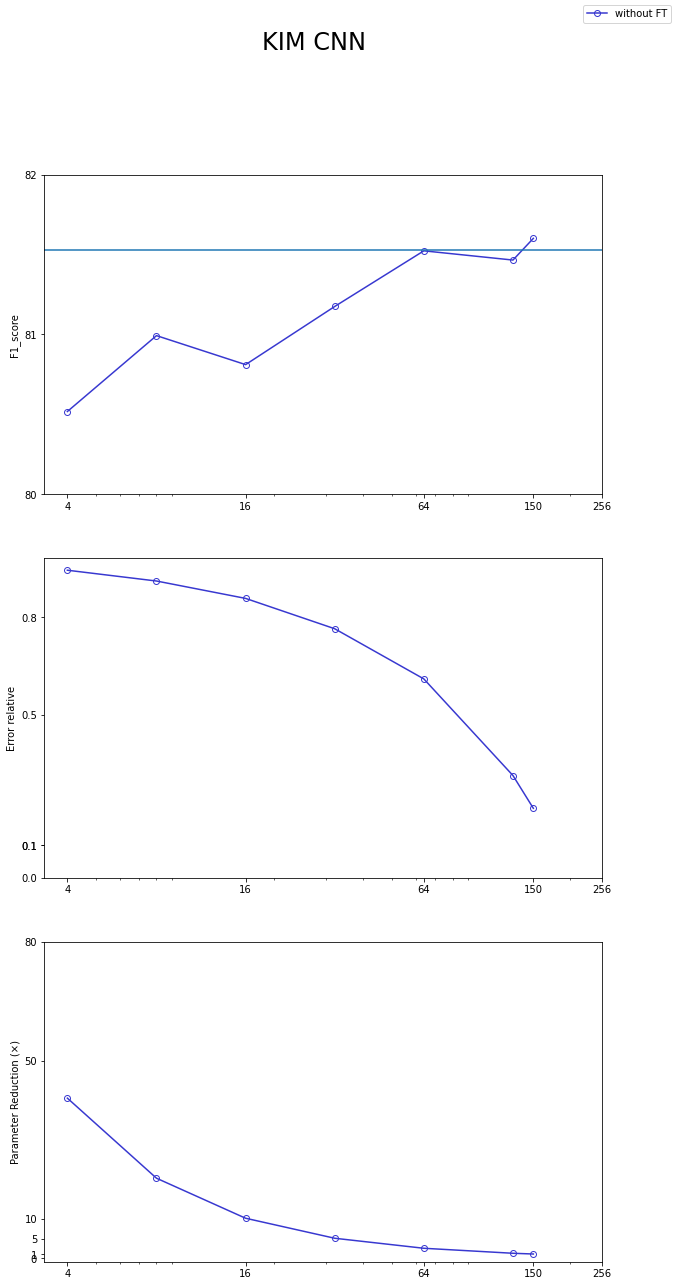

In [65]:
x = rank_test

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)

x_labels = [4, 16, 64, 150, 256]
err_ticks = [80,81,82]
err_ticks_2 = [0,0.1,0.5,0.8, 0.10]
err_ticks_3 = [0,1,5,10,50,80]
err_ticks_4 = [100, 80, 60, 40,20,0]

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10, 20))
ax = ax.flatten()

plt.suptitle('KIM CNN', fontsize=24)

ax[0].plot(x, np.array(results)*100, marker='o', mfc='none',  c='#3838D0')
ax[0].axhline(81.53)
ax[0].set_ylabel('F1_score')
ax[0].set_xscale('log')
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[0].set_xticks(x_labels)
ax[0].set_yticks(err_ticks)


ax[1].plot(x, error, marker='o', mfc='none',  c='#3838D0',label='without FT')
#ax[1].plot(x, (reference_ac - np.array(acc))/reference_ac*100, marker='o', mfc='none',  c='r', label='FT')
ax[1].set_ylabel('Error relative')
ax[1].set_xscale('log')
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[1].set_xticks(x_labels)
ax[1].set_yticks(err_ticks_2)


ax[2].plot(x, np.array(nb_weight),marker='o', mfc='none',  c='#3838D0')
ax[2].set_ylabel('Parameter Reduction (×)')
ax[2].set_xscale('log')
ax[2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[2].set_xticks(x_labels)
ax[2].set_yticks(err_ticks_3)
lines = []
labels = []

for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    
fig.legend(lines, labels,           
           loc = 'upper right')
plt.savefig('kim_2.png')
plt.show()

In [58]:
nb_weight

[40.50632911392405,
 20.253164556962027,
 10.126582278481013,
 5.063291139240507,
 2.5316455696202533,
 1.2658227848101267,
 1.080168776371308]

In [102]:
cnn = CNN_classification_2_channel(matrix_weight = torch.from_numpy(np.random.rand(18881,200)).float(), len_sentence=22188, kernel_sizes=kernel_sizes, out_channel=32)
cnn.load_state_dict(torch.load(name))

<All keys matched successfully>

In [103]:
alphas = [0.1, 0.2, 0.5, 0.8]
Conv3 = cnn.block[0][0].weight.detach().numpy()

In [108]:
Conv3.shape

(32, 2, 3, 200)

In [104]:
_, weight = parafac(Conv3, 150)

In [107]:
compteZeros(a)

2602

In [22]:
#data Relative error
def dataRelativeError(Z, A_list):
    X = Algorithm_3.Algorithm_2.outProduct(A_list)
    norm_1 = np.linalg.norm(Z-X)
    return norm_1/np.linalg.norm(Z)

In [105]:
def compteZeros(A_list, epsilon = 1e-8):
    s = 0
    for element in A_list:
        s += np.sum(np.int0(abs(element)>epsilon) == 0)
    return s

In [24]:
from time import process_time
def computeCP_decomp(Z, nb_iteration , rank,  alpha = 0.5):
    liste_dico = []   
    for i in range(nb_iteration):
        print(i)
        dico = Algorithm_3.CP_decomposition(Z, rank = rank, alpha=alpha,list_lambda= np.concatenate([10**np.array(range(-10, 2),dtype='float'), np.array([50*i for i in range(2,15)])]), max_iter=100, verbose=False)
        liste_dico.append(dico)
    return liste_dico

In [25]:
def Estimate_New_rank(tensor, alphas, nb_iter = 3):
    dico_result = {}
    rank = 150
    for alpha in alphas:
        print(alpha)
        dico_result[str(alpha)] = computeCP_decomp(tensor, alpha=alpha, rank = rank, nb_iteration = nb_iter)
    return dico_result

In [26]:
dico_2 = Estimate_New_rank(Conv3 * 1000, alphas, nb_iter = 1)

0.1
0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
0.2
0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
0.5
0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
0.8
0
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [33]:
Algorithm_3.select_best(dico_2['0.5'][0])

'B_0.1'

In [41]:
dico_2['0.8'][0]['A_200.0']

[0.17517381081518257,
 2602,
 [array([[ 0.0476022 , -0.        ,  0.        , ..., -0.53190983,
           0.10967628, -0.        ],
         [-0.10698955, -0.42370894, -0.40717959, ..., -0.32009071,
           0.00548569,  0.        ],
         [ 0.        , -0.7276203 , -0.87468107, ...,  0.82110101,
          -0.89875369, -0.73053902],
         ...,
         [-0.05456949, -0.30552391,  0.        , ...,  0.        ,
           0.20061272, -0.36354156],
         [-0.        ,  0.51460423,  0.63437549, ...,  0.25185095,
          -1.08985871,  0.20594064],
         [-0.52990773,  0.71041603,  1.22612298, ..., -0.39752352,
          -0.15985312, -0.23602849]]),
  array([[  6.24226412,   9.37260268, -11.2215699 ,   5.79984793,
            5.48700502,  12.22552696,   2.96658174,  -5.61862734,
          -10.27783562,   8.4061267 , -11.74424999,   7.62512922,
            8.70472625,  -6.70503535,  -9.40783605,  -0.        ,
           -7.37986026,   0.        ,  -0.        , -11.58310603,
 

In [45]:
Algorithm_3.Algorithm_2.outProductRank(dico_2['0.5'][0]['A_200.0'][2],2)

array([[[[ 1.66825066e-01,  8.16103161e-01,  2.62333604e-01, ...,
           1.01131348e+00, -5.41013085e-01,  4.23112265e-01],
         [-1.52151984e+00, -7.44322889e+00, -2.39260078e+00, ...,
          -9.22363504e+00,  4.93428333e+00, -3.85897468e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-9.21209361e-03, -4.50652825e-02, -1.44860828e-02, ...,
          -5.58448121e-02,  2.98747863e-02, -2.33642935e-02],
         [ 8.40184484e-02,  4.11015701e-01,  1.32119608e-01, ...,
           5.09329873e-01, -2.72471525e-01,  2.13092894e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],


       [[[-2.82971429e-02, -1.38428765e-01, -4.44974588e-02, ...,
          -1.71540661e-01,  9.17675322e-02, -7.17690006e-02],
         [ 2.58082705e-01,  1.26253277e+00,  4.05836892e-01, ...,
           1.56452820e+00, -8.36

In [48]:
2600/(150*(200+32+5))*100

7.313642756680731

In [124]:
dico_2['0.8'][0]['A_120.0'][0]

0.15378300385382404

In [105]:
save = dico_1['0.8'][0]['B_0.001'][2]
for i in range(len(save)):
    save[i] = save[i].tolist()

In [109]:
np.save('testnp_2.npy', save)

In [109]:
a = np.load('testnp.npy', allow_pickle=True)
a = a.tolist()
for i in range(len(a)):
    a[i] = np.array(a[i])

In [110]:
a

[array([[ 0.72371349, -0.75058135,  0.13046356, ...,  1.37684344,
          2.69750714,  0.96126773],
        [-0.06876679, -0.19426845,  0.50019097, ...,  0.89924371,
          2.73820613,  0.32673125],
        [-0.66812808, -1.11412642, -2.34828862, ..., -0.92622774,
          2.73735793, -1.50072895],
        ...,
        [-0.59364785,  0.23438756,  0.26044497, ..., -0.18966819,
          4.43021894,  0.94505738],
        [ 0.40111741, -0.25803939, -0.19873224, ..., -0.19949625,
         -3.88872083,  1.02302879],
        [-2.31808921,  0.35161352, -0.75357615, ...,  0.20246578,
         -2.37090364, -6.08126117]]),
 array([[ 8.19224774e+00, -1.99518427e+00, -1.26551624e+00,
         -6.74749839e-01,  2.34151138e+00, -1.58434875e+00,
         -2.94544985e+00, -1.07536995e+00,  1.38343779e+00,
          9.90350204e-01, -1.30618444e+00,  1.11833210e+00,
          4.47420762e+00, -1.35758276e+00,  1.41209926e+00,
          5.83546821e-02,  1.29412590e-01, -3.36967979e-01,
         -2.3

In [136]:
numero = 0
kernel_sizes = [3,4,5]
name = str(numero) +'_2.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN_classification_2_channel(matrix_weight = torch.from_numpy(np.random.rand(18881,200)).float(), len_sentence=22188, kernel_sizes=kernel_sizes, out_channel=32)
cnn.load_state_dict(torch.load(name))

<All keys matched successfully>

In [138]:
cnn.decomposition(rank1=1)

0.9798511


In [128]:
cnn.decomposition_layer_1_elastic(a[0], a[1], a[2], a[3])

AttributeError: 'Sequential' object has no attribute 'dilation'

In [141]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

CNN_classification_2_channel(
  (embbeding_1): Embedding(18881, 200)
  (embbeding_2): Embedding(18881, 200)
  (block): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Conv2d(1, 1, kernel_size=(3, 1), stride=(1, 1), bias=False)
        (2): Conv2d(1, 1, kernel_size=(1, 200), stride=(1, 1), bias=False)
        (3): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ReLU()
      (2): Flatten()
      (3): MaxPool1d(kernel_size=22186, stride=22186, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(4, 200), stride=(1, 1))
      (1): ReLU()
      (2): Flatten()
      (3): MaxPool1d(kernel_size=22185, stride=22185, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(2, 32, kernel_size=(5, 200), stride=(1, 1))
      (1): ReLU()
      (2): Flatten()
      (3): MaxPool1d(kernel_size=22184, stride=2218

In [142]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [143]:
with torch.no_grad():
    prediction_loader = iter(DataLoader(DataSet(X_test, Y_test), batch_size = 1, shuffle=False))
    y_pred = get_all_preds(cnn, prediction_loader)
proba, predicted = torch.max(y_pred, 1) 
new_score(Y_test.numpy(), predicted.numpy())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Accuracy: 0.8258839226150767 
 F1: 0.8019604567818746 
 precision : 0.810358491663516 
 recall : 0.7956397028558764 


0.8019604567818746

In [122]:
compteZeros(a)

2